In [7]:
from pathlib import Path
import pandas as pd
import numpy as np
import yaml
from ms_pred.common.plot_utils import *
import pickle
import json
import copy

from collections import defaultdict

# Import sem calc
from scipy.stats import sem

set_style()

/home/samlg/.conda/envs/ms-gen/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
dataset_names = ["nist20", "canopus_train_public"]
res_folder = f"../results/figs_scarf/scarf_weave_acc/"
res_folder = Path(res_folder)
res_folder.mkdir(parents=True, exist_ok=True)

In [9]:
names = [
    "CFM-ID",
    "3DMolMS",
    "FixedVocab",
    "NEIMS (FFN)",
    "NEIMS (GNN)",
    "SCARF",
]

dataset_to_res = {}
for dataset_name in dataset_names:
    yaml_files = defaultdict(lambda : [])
    for seed in [1,2,3]:    
        results_files = [
            f"../results/cfm_id_{dataset_name}/split_1/preds/pred_eval.yaml",
            f"../results/molnetms_baseline_{dataset_name}/split_1_rnd{seed}/preds/pred_eval.yaml",
            f"../results/graff_ms_baseline_{dataset_name}/split_1_rnd{seed}/preds/pred_eval.yaml",
            f"../results/ffn_baseline_{dataset_name}/split_1_rnd{seed}/preds/pred_eval.yaml",
            f"../results/gnn_baseline_{dataset_name}/split_1_rnd{seed}/preds/pred_eval.yaml",
            f"../results/scarf_inten_{dataset_name}/split_1_rnd{seed}/preds/pred_eval.yaml",
        ]

        for i, j in zip(names, results_files):
            yaml_files[i].append(yaml.safe_load(open(j, "r")))
    dataset_to_res[dataset_name] = yaml_files

In [10]:
name_to_time = {
    "CFM-ID": "../results/cfm_id_nist20_timer/time_out.json",
    "3DMolMS": "../results/molnetms_baseline_nist20/split_1_rnd1/time_out.json",
    "FixedVocab": "../results/graff_ms_baseline_nist20/split_1_rnd1/time_out.json",
    "NEIMS (FFN)": "../results/ffn_baseline_nist20/split_1_rnd1/time_out.json",
    "NEIMS (GNN)": "../results/gnn_baseline_nist20/split_1_rnd1/time_out.json",
    "SCARF": "../results/scarf_inten_nist20/split_1_rnd1/time_out.json",
}
name_to_seconds = {
    i: yaml.safe_load(open(j, "r"))["time (s)"] for i, j in name_to_time.items()
}

In [11]:
dataset_to_res["nist20"]["SCARF"][0].keys()

dict_keys(['avg_cos_sim', 'avg_cos_sim_zero_pep', 'avg_coverage', 'avg_frac_valid', 'avg_len_pred', 'avg_len_targ', 'avg_mse', 'avg_overlap_coeff', 'data_folder', 'dataset', 'individuals', 'sem_cos_sim', 'sem_cos_sim_zero_pep', 'sem_coverage', 'sem_frac_valid', 'sem_len_pred', 'sem_len_targ', 'sem_mse', 'sem_overlap_coeff', 'std_cos_sim', 'std_cos_sim_zero_pep', 'std_coverage', 'std_frac_valid', 'std_len_pred', 'std_len_targ', 'std_mse', 'std_overlap_coeff'])

In [12]:
out_df = []
for dataset_name, yaml_files in dataset_to_res.items():
    for k, v in yaml_files.items():
        new_entry = {
            "Method": k,
            "Cosine sim.": np.mean([vv['avg_cos_sim'] for vv in v]),
            "Cosine sim. sem": sem([vv['avg_cos_sim'] for vv in v])   ,  ###v["sem_cos_sim"],

            "Cosine sim. (no PEP)": np.mean([vv['avg_cos_sim_zero_pep'] for vv in v]),
            "Cosine sim. sem (no PEP)": sem([vv['avg_cos_sim_zero_pep'] for vv in v])   ,  ###v["sem_cos_sim"],

            "Coverage": np.mean([vv['avg_coverage'] for vv in v]),
            "Coverage sem": sem([vv['avg_coverage'] for vv in v])   ,  ###v["sem_cos_sim"],
            
            "Valid": np.mean([vv['avg_frac_valid'] for vv in v]),
            "Valid sem": sem([vv['avg_frac_valid'] for vv in v])   ,  ###v["sem_cos_sim"],

            "Time (s)": name_to_seconds[k],
            "Dataset": dataset_name,
        }
        out_df.append(new_entry)
out_df = pd.DataFrame(out_df)

In [13]:
out_df_pivot = out_df.pivot_table(
    index="Method",
    columns="Dataset",
    values=[
        "Cosine sim.",
        "Coverage",
        "Valid",
        "Time (s)",
    ],
)
out_df_pivot_sorted = out_df_pivot.loc[names]

out_df_pivot_sorted = out_df_pivot_sorted.swaplevel(0, 1, axis=1).round(3)

metric_order = {"Cosine sim.": 1, "Coverage": 2, "Valid": 3, "Time (s)": 4}
metric_order = ["Cosine sim.", "Coverage", "Valid", "Time (s)"]
dataset_order = {
    "nist20": 1,
    "canopus_train_public": 2,
}
dataset_order = ["nist20", "canopus_train_public"]



# Create a new MultiIndex with the custom sort order
new_index = pd.MultiIndex.from_product(
    [dataset_order, metric_order], names=["Dataset", "Metric"]
)

out_df_pivot_sorted = out_df_pivot_sorted.loc[:, new_index]

# Drop time
out_df_pivot_sorted = out_df_pivot_sorted.drop(
    columns=[("nist20", "Time (s)")]
)

# Sort columns and make time last
out_df_pivot_sorted.index.name = None
display(out_df_pivot_sorted)
latex = out_df_pivot_sorted.to_latex(
    caption="Spectra prediction accuracy", label="tab:spec_acc"
)
print(latex)

# Output to file
with open(res_folder / "scarf_weave_acc.tex", "w") as f:
    f.write(latex)

Dataset          nist20                 canopus_train_public                  \
            Cosine sim. Coverage  Valid          Cosine sim. Coverage  Valid   
CFM-ID            0.412    0.278  1.000                0.377    0.235  1.000   
3DMolMS           0.510    0.734  0.945                0.394    0.507  0.919   
FixedVocab        0.704    0.788  0.997                0.568    0.563  0.998   
NEIMS (FFN)       0.617    0.746  0.948                0.491    0.524  0.949   
NEIMS (GNN)       0.694    0.780  0.947                0.521    0.547  0.943   
SCARF             0.726    0.807  1.000                0.536    0.552  1.000   

Dataset                
             Time (s)  
CFM-ID       1114.652  
3DMolMS         3.491  
FixedVocab      5.519  
NEIMS (FFN)     3.907  
NEIMS (GNN)     4.921  
SCARF          21.061

\begin{table}
\centering
\caption{Spectra prediction accuracy}
\label{tab:spec_acc}
\begin{tabular}{lrrrrrrr}
\toprule
Dataset & \multicolumn{3}{l}{nist20} & \multicolumn{4}{l}{canopus\_train\_public} \\
{} & Cosine sim. & Coverage &  Valid &          Cosine sim. & Coverage &  Valid &  Time (s) \\
\midrule
CFM-ID      &       0.412 &    0.278 &  1.000 &                0.377 &    0.235 &  1.000 &  1114.652 \\
3DMolMS     &       0.510 &    0.734 &  0.945 &                0.394 &    0.507 &  0.919 &     3.491 \\
FixedVocab  &       0.704 &    0.788 &  0.997 &                0.568 &    0.563 &  0.998 &     5.519 \\
NEIMS (FFN) &       0.617 &    0.746 &  0.948 &                0.491 &    0.524 &  0.949 &     3.907 \\
NEIMS (GNN) &       0.694 &    0.780 &  0.947 &                0.521 &    0.547 &  0.943 &     4.921 \\
SCARF       &       0.726 &    0.807 &  1.000 &                0.536 &    0.552 &  1.000 &    21.061 \\
\bottomrule
\end{tabular}
\end{table}



/tmp/ipykernel_2257064/2326748670.py:40: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = out_df_pivot_sorted.to_latex(


In [14]:
out_df_temp = out_df.copy()
# rewrite cosine sim column with f"cos sim \pm cosine sem using list comprehension
out_df_temp["Cosine sim."] = [
    rf"${i:.3f} \pm {j:.3f}$"
    for i, j in zip(out_df_temp["Cosine sim."], out_df_temp["Cosine sim. sem"])
]
# Rewrite coverage column with f"coverage \pm coverage sem using list comprehension
out_df_temp["Coverage"] = [
    rf"${i:.3f} \pm {j:.3f}$"
    for i, j in zip(out_df_temp["Coverage"], out_df_temp["Coverage sem"])
]
# Same for valid
out_df_temp["Valid"] = [
    rf"${i:.2f} \pm {j:.3f}$"
    for i, j in zip(out_df_temp["Valid"], out_df_temp["Valid sem"])
]
out_df_temp["Time (s)"] = [rf"${i:.1f}$" for i in out_df_temp["Time (s)"]]

out_df_pivot = out_df_temp.pivot_table(
    index="Method",
    columns="Dataset",
    values=[
        "Cosine sim.",
        "Coverage",
        "Valid",
        "Time (s)",
    ],
    aggfunc=lambda x: "&".join(x),
)

out_df_pivot_sorted = out_df_pivot.loc[names]
out_df_pivot_sorted = out_df_pivot_sorted.swaplevel(0, 1, axis=1).round(3)

metric_order = {"Cosine sim.": 1, "Coverage": 2, "Valid": 3, "Time (s)": 4}
metric_order = ["Cosine sim.", "Coverage", "Valid", "Time (s)"]
dataset_order = {
    "nist20": 2,
    "canopus_train_public": 1,
}
dataset_order = ["nist20", "canopus_train_public"]


# Create a new MultiIndex with the custom sort order
new_index = pd.MultiIndex.from_product(
    [dataset_order, metric_order], names=["Dataset", "Metric"]
)
print(out_df_pivot_sorted.columns)

out_df_pivot_sorted = out_df_pivot_sorted.loc[:, new_index]

# Drop time
out_df_pivot_sorted = out_df_pivot_sorted.drop(
    columns=[("nist20", "Time (s)")]
)

# Sort columns and make time last
out_df_pivot_sorted.index.name = None
display(out_df_pivot_sorted)
latex = out_df_pivot_sorted.to_latex(
    caption="Spectra prediction accuracy", label="tab:spec_acc", escape=False
)
print(latex)

# Output to file 
with open(res_folder / "scarf_weave_acc2.tex", "w") as f:
    f.write(latex)

MultiIndex([('canopus_train_public', 'Cosine sim.'),
            (              'nist20', 'Cosine sim.'),
            ('canopus_train_public',    'Coverage'),
            (              'nist20',    'Coverage'),
            ('canopus_train_public',    'Time (s)'),
            (              'nist20',    'Time (s)'),
            ('canopus_train_public',       'Valid'),
            (              'nist20',       'Valid')],
           names=['Dataset', None])


Dataset                 nist20                                       \
                   Cosine sim.           Coverage             Valid   
CFM-ID       $0.412 \pm 0.000$  $0.278 \pm 0.000$  $1.00 \pm 0.000$   
3DMolMS      $0.510 \pm 0.000$  $0.734 \pm 0.001$  $0.94 \pm 0.001$   
FixedVocab   $0.704 \pm 0.000$  $0.788 \pm 0.000$  $1.00 \pm 0.000$   
NEIMS (FFN)  $0.617 \pm 0.000$  $0.746 \pm 0.001$  $0.95 \pm 0.001$   
NEIMS (GNN)  $0.694 \pm 0.000$  $0.780 \pm 0.000$  $0.95 \pm 0.001$   
SCARF        $0.726 \pm 0.001$  $0.807 \pm 0.000$  $1.00 \pm 0.000$   

Dataset     canopus_train_public                                       \
                     Cosine sim.           Coverage             Valid   
CFM-ID         $0.377 \pm 0.000$  $0.235 \pm 0.000$  $1.00 \pm 0.000$   
3DMolMS        $0.394 \pm 0.002$  $0.507 \pm 0.001$  $0.92 \pm 0.000$   
FixedVocab     $0.568 \pm 0.002$  $0.563 \pm 0.001$  $1.00 \pm 0.000$   
NEIMS (FFN)    $0.491 \pm 0.002$  $0.524 \pm 0.001$  $0.95 \pm 0.000$   
NEIMS (GNN)    $0.521 \pm 0.002$  $0.547 \pm 0.003$  $0.94 \pm 0.001$   
SCARF          $0.536 \pm 0.007$  $0.552 \pm 0.008$  $1.00 \pm 0.000$   

Dataset                
             Time (s)  
CFM-ID       $1114.7$  
3DMolMS         $3.5$  
FixedVocab      $5.5$  
NEIMS (FFN)     $3.9$  
NEIMS (GNN)     $4.9$  
SCARF          $21.1$

\begin{table}
\centering
\caption{Spectra prediction accuracy}
\label{tab:spec_acc}
\begin{tabular}{llllllll}
\toprule
Dataset & \multicolumn{3}{l}{nist20} & \multicolumn{4}{l}{canopus_train_public} \\
{} &        Cosine sim. &           Coverage &             Valid &          Cosine sim. &           Coverage &             Valid &  Time (s) \\
\midrule
CFM-ID      &  $0.412 \pm 0.000$ &  $0.278 \pm 0.000$ &  $1.00 \pm 0.000$ &    $0.377 \pm 0.000$ &  $0.235 \pm 0.000$ &  $1.00 \pm 0.000$ &  $1114.7$ \\
3DMolMS     &  $0.510 \pm 0.000$ &  $0.734 \pm 0.001$ &  $0.94 \pm 0.001$ &    $0.394 \pm 0.002$ &  $0.507 \pm 0.001$ &  $0.92 \pm 0.000$ &     $3.5$ \\
FixedVocab  &  $0.704 \pm 0.000$ &  $0.788 \pm 0.000$ &  $1.00 \pm 0.000$ &    $0.568 \pm 0.002$ &  $0.563 \pm 0.001$ &  $1.00 \pm 0.000$ &     $5.5$ \\
NEIMS (FFN) &  $0.617 \pm 0.000$ &  $0.746 \pm 0.001$ &  $0.95 \pm 0.001$ &    $0.491 \pm 0.002$ &  $0.524 \pm 0.001$ &  $0.95 \pm 0.000$ &     $3.9$ \\
NEIMS (GNN) &  $0.694 \pm 0.000$ 

/tmp/ipykernel_2257064/1776311997.py:59: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = out_df_pivot_sorted.to_latex(


### Directly compare precursor and no precursor

In [9]:
names_temp = copy.deepcopy(names)

In [10]:
out_df_pivot = out_df.pivot_table(
    index="Method", columns="Dataset", values=["Cosine sim.", "Cosine sim. (no PEP)"]
)
out_df_pivot_sorted = out_df_pivot.loc[names]

out_df_pivot_sorted = out_df_pivot_sorted.swaplevel(0, 1, axis=1).round(3)

metric_order = {"Cosine sim.": 1, "Coverage": 2, "Valid": 3, "Time (s)": 4}
metric_order = ["Cosine sim.", "Cosine sim. (no PEP)"]
dataset_order = {
    "nist20": 1,
    "canopus_train_public": 2,
}
dataset_order = ["nist20", "canopus_train_public"]


# Create a new MultiIndex with the custom sort order
new_index = pd.MultiIndex.from_product(
    [dataset_order, metric_order], names=["Dataset", "Metric"]
)

out_df_pivot_sorted = out_df_pivot_sorted.loc[:, new_index]

# Sort columns and make time last
out_df_pivot_sorted.index.name = None
display(out_df_pivot_sorted)
latex = out_df_pivot_sorted.to_latex(
    caption="Spectra prediction accuracy", label="tab:spec_acc"
)
print(latex)

# Output to file
with open(res_folder / "scarf_weave_acc_pep.tex", "w") as f:
    f.write(latex)

Dataset          nist20                      canopus_train_public  \
            Cosine sim. Cosine sim. (no PEP)          Cosine sim.   
CFM-ID            0.412                0.289                0.377   
3DMolMS           0.510                0.517                0.394   
FixedVocab        0.704                0.637                0.568   
NEIMS (FFN)       0.617                0.557                0.491   
NEIMS (GNN)       0.694                0.620                0.521   
SCARF             0.726                0.663                0.536   

Dataset                           
            Cosine sim. (no PEP)  
CFM-ID                     0.326  
3DMolMS                    0.390  
FixedVocab                 0.505  
NEIMS (FFN)                0.454  
NEIMS (GNN)                0.477  
SCARF                      0.466

\begin{table}
\centering
\caption{Spectra prediction accuracy}
\label{tab:spec_acc}
\begin{tabular}{lrrrr}
\toprule
Dataset & \multicolumn{2}{l}{nist20} & \multicolumn{2}{l}{canopus\_train\_public} \\
{} & Cosine sim. & Cosine sim. (no PEP) &          Cosine sim. & Cosine sim. (no PEP) \\
\midrule
CFM-ID      &       0.412 &                0.289 &                0.377 &                0.326 \\
3DMolMS     &       0.510 &                0.517 &                0.394 &                0.390 \\
FixedVocab  &       0.704 &                0.637 &                0.568 &                0.505 \\
NEIMS (FFN) &       0.617 &                0.557 &                0.491 &                0.454 \\
NEIMS (GNN) &       0.694 &                0.620 &                0.521 &                0.477 \\
SCARF       &       0.726 &                0.663 &                0.536 &                0.466 \\
\bottomrule
\end{tabular}
\end{table}



/tmp/ipykernel_2256513/3717354200.py:27: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = out_df_pivot_sorted.to_latex(


### Acc by various property subsets

In [15]:
out_df = []
for dataset_name, yaml_files in dataset_to_res.items():
    for k, v in yaml_files.items():
        individuals = [ind for vv in v for ind in vv["individuals"]]
        for ind in individuals:
            ind["method"] = k
            ind["dataset"] = dataset_name
            out_df.append(ind)
out_df = pd.DataFrame(out_df)

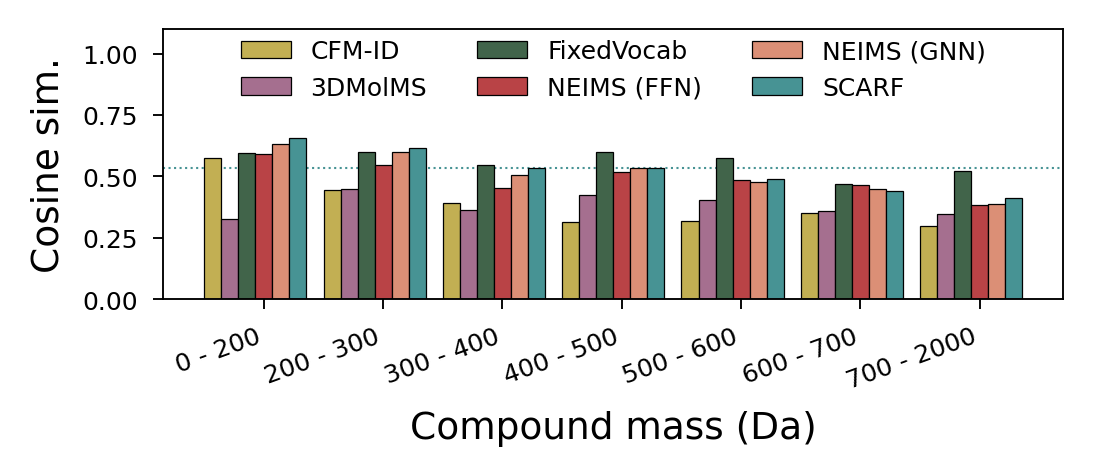

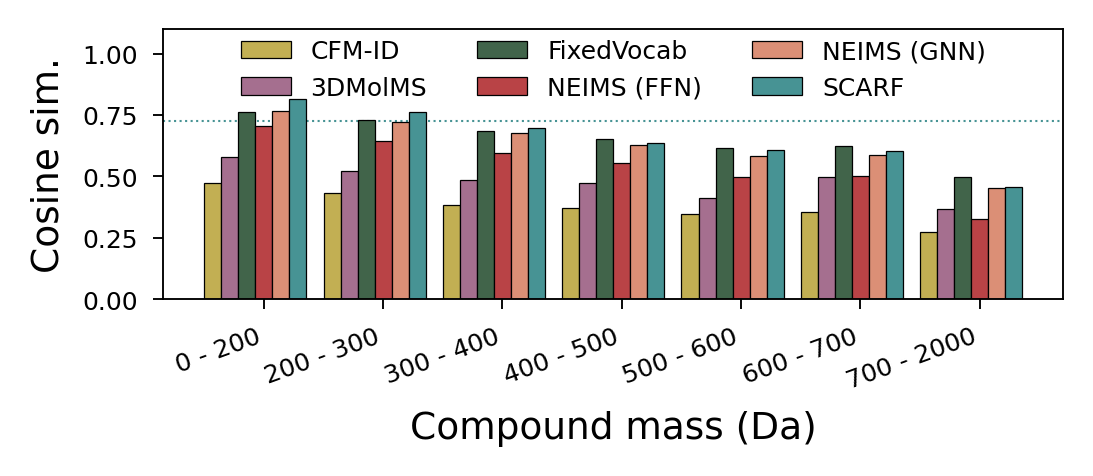

In [16]:
color_dict = method_colors
methods = [*names, "ghost_method"]
bins = np.array(
    [
        "0 - 200",
        "200 - 300",
        "300 - 400",
        "400 - 500",
        "500 - 600",
        "600 - 700",
        "700 - 2000",
    ]
)
for dataset, sub_df in out_df.groupby("dataset"):
    figsize = (3, 0.9)
    metric = "cos_sim"
    method_col = "method"
    groupby_col = "mass_bin"
    # Plot a groupbed barplot where each method has a color (color_dict) and x axis is the groupby col
    fig = plt.figure(figsize=figsize, dpi=300)
    ax = fig.add_subplot(111)
    x_values = np.arange(len(pd.unique(sub_df[groupby_col])))
    shift_val = 1 / (len(methods))
    shift_bw = np.arange(len(bins)).repeat(len(methods))
    # Plot scarf mean accuracy in dotted horizontal line
    scarf_mean_acc = sub_df[sub_df[method_col] == "SCARF"][metric].mean()
    ax.axhline(
        y=scarf_mean_acc,
        color=color_dict["SCARF"],
        linestyle="dotted",
        linewidth=0.5,
        zorder=0,
    )

    # Loop through each method and plot a grouped bar
    for idx, method in enumerate(methods):
        if method == "ghost_method":
            continue
        y_values = (
            sub_df[sub_df[method_col] == method].groupby(groupby_col)[metric].mean()
        )
        std_values = (
            sub_df[sub_df[method_col] == method].groupby(groupby_col)[metric].std()
        )
        counts = (
            sub_df[sub_df[method_col] == method].groupby(groupby_col)[metric].count()
        )

        y_values = y_values[bins]
        counts = counts[bins]
        std_values = std_values[bins] * 1.96 / np.sqrt(counts)
        ax.bar(
            x_values + idx * shift_val,  # Adjust the spacing between bars if needed
            y_values,
            # yerr=std_values,  # Add error bars representing the standard deviation
            capsize=0.6,  # Adjust cap size of the error bars
            error_kw={"elinewidth": 0.5, "capthick": 0.5},  # Adjust error bar thickness
            width=shift_val,  # Adjust the bar width if needed
            label=method,
            color=color_dict.get(
                method, "gray"
            ),  # Use gray if method color is not defined
            edgecolor="black",  # Add a black edge to the bars
            linewidth=0.3,
            # Make err size smaller
        )

    # Set labels and title
    ax.set_xlabel("Compound mass (Da)")
    ax.set_ylabel("Cosine sim.")
    ax.set_xticks(x_values + (len(methods) - 1) * shift_val / 2)
    ax.set_xticklabels(
        bins, rotation=20, ha="right"
    )  # Use index of group_means as x tick labels
    # Use 3 columns/two rows and poostiion in top of chart inset
    ax.legend(
        loc="upper center",
        borderaxespad=0.0,
        frameon=False,
        ncol=3,
        bbox_to_anchor=(0.5, 1.0),
    )
    ax.set_ylim([0, 1.1])
    set_size(*figsize, ax)

    plt.savefig(
        res_folder / f"cosine_sim_{dataset}_mass.pdf",
        bbox_inches="tight",
        dpi=300,
        transparent=True,
    )

    # Plot a barplot of sub_df where

## Accuracy by chemical class

In [17]:
ikey_to_class_files = [
    f"../results/dataset_analyses/{i}/ikey_to_classes.p" for i in dataset_names
]
ikey_to_class = {
    k: v for f in ikey_to_class_files for k, v in pickle.load(open(f, "rb")).items()
}

In [18]:
new_df = []
for _, row in out_df.iterrows():
    new_dict = row.to_dict()
    ikey = new_dict["inchi"]
    classif_out = ikey_to_class[ikey]
    for chem_class in classif_out.get("superclass_results", []):
        temp_dict = dict(**new_dict, chem_class=chem_class)
        new_df.append(temp_dict)
class_df = pd.DataFrame(new_df)

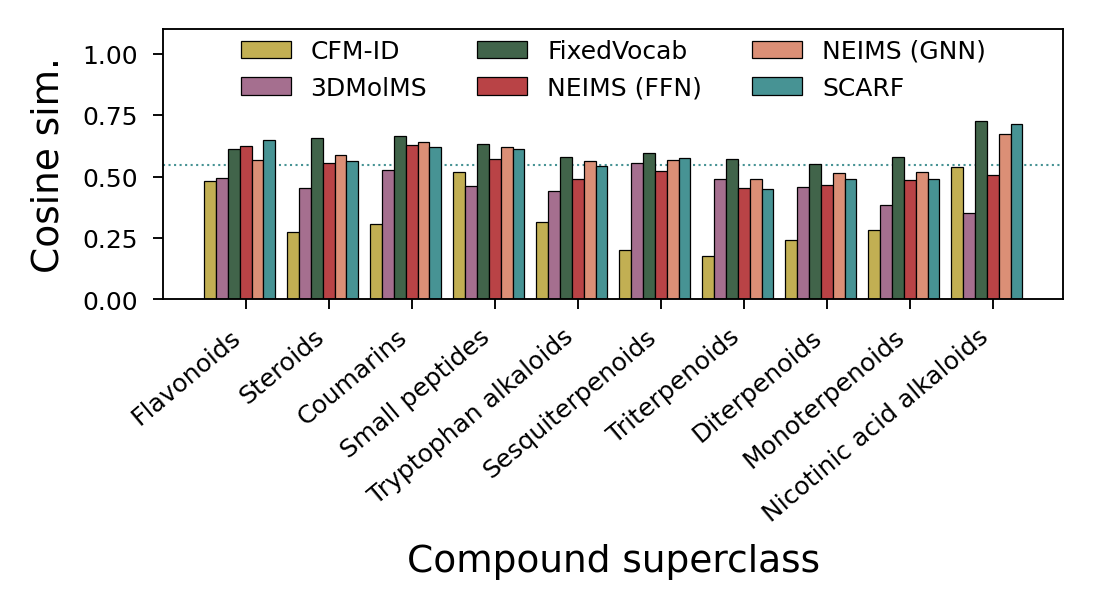

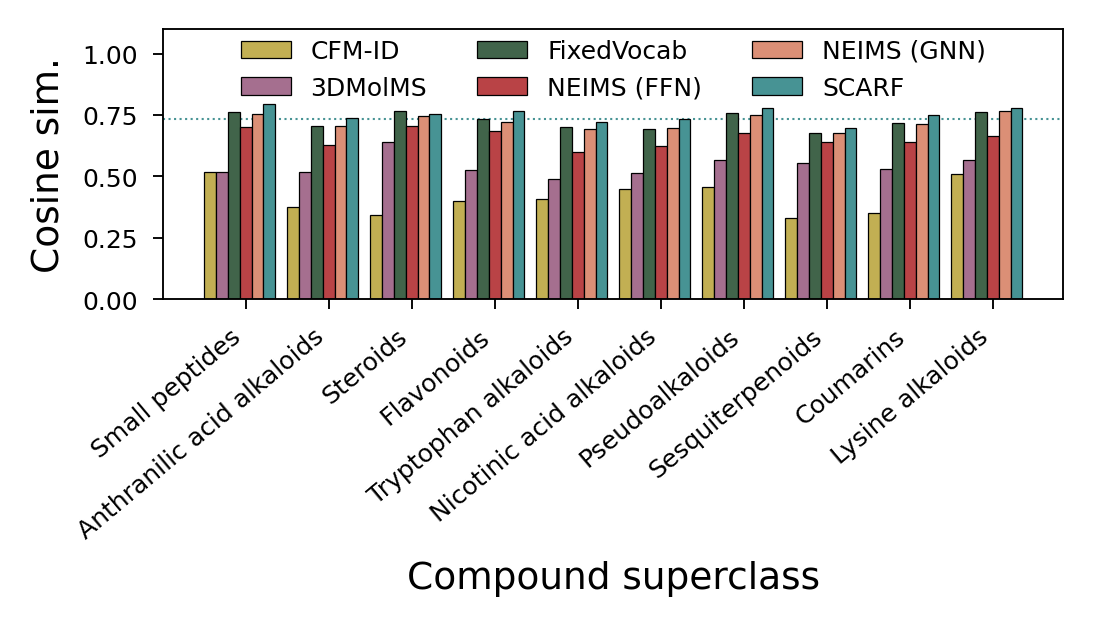

In [19]:
num_classes = 10
color_dict = method_colors
methods = [*names, "ghost_method"]
for dataset, sub_df in class_df.groupby("dataset"):
    figsize = (3, 0.9)
    metric = "cos_sim"
    method_col = "method"
    groupby_col = "chem_class"
    # Get 10 most common classes
    classes = (
        sub_df.groupby(groupby_col)[metric]
        .count()
        .sort_values(ascending=False)
        .head(num_classes)
        .index
    )

    # Plot a groupbed barplot where each method has a color (color_dict) and x axis is the groupby col
    fig = plt.figure(figsize=figsize, dpi=300)
    ax = fig.add_subplot(111)
    x_values = np.arange(len(classes))
    shift_val = 1 / (len(methods))
    shift_bw = np.arange(len(classes)).repeat(len(methods))

    # Plot scarf mean accuracy in dotted horizontal line
    scarf_mean_acc = sub_df[sub_df[method_col] == "SCARF"][metric].mean()
    ax.axhline(
        y=scarf_mean_acc,
        color=color_dict["SCARF"],
        linestyle="dotted",
        linewidth=0.5,
        zorder=0,
    )

    # Loop through each method and plot a grouped bar
    for idx, method in enumerate(methods):
        if method == "ghost_method":
            continue
        y_values = (
            sub_df[sub_df[method_col] == method].groupby(groupby_col)[metric].mean()
        )
        std_values = (
            sub_df[sub_df[method_col] == method].groupby(groupby_col)[metric].std()
        )
        counts = (
            sub_df[sub_df[method_col] == method].groupby(groupby_col)[metric].count()
        )

        y_values = y_values[classes]
        counts = counts[classes]
        std_values = std_values[classes] * 1.96 / np.sqrt(counts)
        ax.bar(
            x_values + idx * shift_val,  # Adjust the spacing between bars if needed
            y_values,
            # yerr=std_values,  # Add error bars representing the standard deviation
            capsize=0.6,  # Adjust cap size of the error bars
            error_kw={"elinewidth": 0.5, "capthick": 0.5},  # Adjust error bar thickness
            width=shift_val,  # Adjust the bar width if needed
            label=method,
            color=color_dict.get(
                method, "gray"
            ),  # Use gray if method color is not defined
            edgecolor="black",  # Add a black edge to the bars
            linewidth=0.3,
            # Make err size smaller
        )

    # Set labels and title
    ax.set_xlabel("Compound superclass")
    ax.set_ylabel("Cosine sim.")
    ax.set_xticks(x_values + (len(methods) - 1) * shift_val / 2)
    ax.set_xticklabels(
        classes, rotation=40, ha="right"
    )  # Use index of group_means as x tick labels
    # Use 3 columns/two rows and poostiion in top of chart inset
    ax.legend(
        loc="upper center",
        borderaxespad=0.0,
        frameon=False,
        ncol=3,
        bbox_to_anchor=(0.5, 1.0),
    )
    ax.set_ylim([0, 1.1])
    set_size(*figsize, ax)

    plt.savefig(
        res_folder / f"cosine_sim_{dataset}_chem_class.pdf",
        bbox_inches="tight",
        dpi=300,
        transparent=True,
    )

    # Plot a barplot of sub_df where